## Sources:
- https://towardsdatascience.com/understanding-generative-adversarial-networks-4dafc963f2ef
- https://github.com/sudiptodip15/ClusterGAN
- Paper: ClusterGAN : Latent Space Clustering in Generative Adversarial Networks

# Implementing a ClusterGAN in Pytorch on the MNIST Dataset


- Goal is to implement a simple clusterGAN to understand the fundamental concepts behind clusterGAN with solid understanding for further application on several other cluster problems (as for synthetic data in general and not for images). Main source is this paper on clusterGANs https://arxiv.org/abs/1809.03627

## GAN Concept in a nutshell:
In an Generative Adversarial Network we have two neural networks - a discriminator (D) and a generator (G). Based on the MNIST Dataset, which is a dataset of handwritten numbers from 0-9, the discriminator learns to distinguish if the given image of the number is real (out of the MNIST Dataset) or fake (created by the generator). That means that it learns on images out of the dataset and images created by the generator. According to that the generator (starting from random images) learns to draw better and better handwritten numbers so that in the end the discriminator cant differentiate if the given nr is real or fake.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions.normal as normal
import torchvision
from torchvision import transforms
from torch.utils import data
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn import datasets
from itertools import chain as ichain
import time
from IPython.display import clear_output
import sys

## Loading MNIST Dataset

In [2]:
from torchvision.datasets import MNIST
#https://github.com/Manuel4131/GoMNIST/tree/master/data

data_train = MNIST('~/pytorch_data', train=True, download=True,transform = transforms.Compose(
    [transforms.ToTensor()]))

In [3]:
BATCH_SIZE = 32

In [5]:
X_train = data_train.train_data
#print(X_train[0])
#print(X_train[0].shape)
X_train = preprocess_img(X_train)
y_train = data_train.targets
print(len(X_train))
print(len(y_train))

C:\Users\DESEDIT\AppData\Local\Continuum\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


60000
60000


# Testing if Deprocessing works 

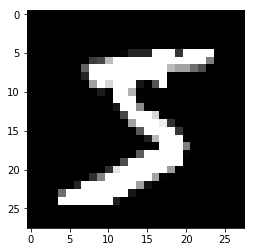

In [6]:
test_img = deprocess(X_train[0])
plt.imshow(test_img, cmap = "gray")

# Create final DataLoader from preprocessed dataset

In [7]:
import torch.utils.data as data_utils
dataset = data_utils.TensorDataset(X_train, y_train)

In [8]:
data_loader = torch.utils.data.DataLoader(dataset,
                                          batch_size=32,
                                          shuffle=True)

# Create Helper-Functions
- generate random inputs for the generator 
- to preprocess /deprocess
- create real / fake labels

In [9]:
# create normal dist with sigma 0.1 ~ scale
a = normal.Normal(torch.Tensor([0.0]), scale = 0.1)
vec = [a.sample() for i in range(0,10)]
vec = torch.FloatTensor(vec)
print(vec)
vec.shape

tensor([-0.1595,  0.1321,  0.0206, -0.0859,  0.0439, -0.0820, -0.0266, -0.0119,
        -0.0786,  0.0740])


torch.Size([10])

In [10]:
zn, zc, idx = generator_input_sampler(10, 4)
print(zn)
idx.shape

NameError: name 'generator_input_sampler' is not defined

In [11]:
def generator_input_sampler(latent_space, batch_size = BATCH_SIZE, nc = 10, clip_range =0.6, sigma = 0.1):
    """ 
    Generates latent space values clipped to a given range (default is -0.6 and 0.6), zc and indexes of zc depending on the number of classes >nc<
    \n
    Input: \n
    latentspace size, batchsize, nc default = 10
    \n
    Output:\n
    latentspace vector, zc, zc_idx
    """
    
    batch = sigma * torch.randn((batch_size, latent_space))     # batch prior of normal random variables
    zn = torch.FloatTensor(np.clip(batch.numpy(), -clip_range, clip_range)) 
    zc_idx = torch.empty(batch_size, dtype=torch.long)
    zc_idx = zc_idx.random_(nc)      # random index for one hot encoded vector
    zc = torch.Tensor(batch_size, nc).fill_(0)
    zc = zc.scatter_(1, zc_idx.unsqueeze(1), 1.) # one hot encoded vector 
    return zn, zc, zc_idx

In [24]:
from torch.autograd import grad as torch_grad
def preprocess_img(img):
    """
    Preprocess the images that the are normalized and clipped to a range between -1 and 1
    Input: Batch of images
    Output: Batch of normalized and clipped images
    """
    img = (img.float() / 255- 0.5) * 2
    img = torch.FloatTensor(np.clip(img.numpy(), -1, 1))      
    return img

def deprocess(x):
    """
    Deprocess the normalized vector images back to image format in range 0,255 
    Input: norm image vector with size (1,784)
    Output: image Tensor size (28,28)
    """
    x = (x.detach() / 2 + 1) * 255
    x = torch.clamp(x, min = 0, max = 255)
    return x.view(28,28)

def make_labels(size):
    # returns real and fake lables
    return torch.ones(size,1), torch.zeros(size,1)

class View(nn.Module):
    def __init__(self, shape):
        super(View, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(x.size(0),*self.shape)

def calc_gradient_penalty(netD, real_data, generated_data):
    """
    
    """
    # GP strength
    LAMBDA = 10

    b_size = real_data.size()[0]

    # Calculate interpolation
    alpha = torch.rand(b_size,1, 1, 1)
    real_data = real_data.unsqueeze(1)
    alpha = alpha.expand_as(real_data)
    
    interpolated = alpha * real_data.data + (1 - alpha) * generated_data.data
    interpolated = interpolated.requires_grad_(True)

    # Calculate probability of interpolated examples
    prob_interpolated = netD(interpolated.squeeze(1))

    # Calculate gradients of probabilities with respect to examples
    gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                           grad_outputs=torch.ones(prob_interpolated.size()),
                           create_graph=True, retain_graph=True)[0]

    # Gradients have shape (batch_size, num_channels, img_width, img_height),
    # so flatten to easily take norm per example in batch
    gradients = gradients.view(b_size, -1)

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

    # Return gradient penalty
    return  (LAMBDA * (gradients_norm - 1.0) ** 2).mean()

def plot(frame_idx, z_error, X_error):
    """
    Plots: || z - E(G(z))||
    and    || X - G(E(X))||
    """
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title("Cycle L2-distance loss")
    plt.plot(z_error, label = "|| z - E(G(z))||", color = "r")
    plt.plot(X_error, label = "|| X - G(E(X))||", color = "b")
    plt.ylabel = "L2-loss"
    plt.legend(loc='upper right')
    plt.show()

# Creating Generator, Encoder and Discriminator

![image.png](imgs\hyperparams.PNG)
![image.png](imgs\architecture.PNG)

In [12]:
class Generator(nn.Module):
    def __init__(self, latent_dim, nr_classes,img_shape = (1,28,28)):
        super(Generator, self).__init__()
        self.img_shape = img_shape
        self.ishape = (128,7,7)
        self.dim = int(np.prod(self.ishape))
        self.network = nn.Sequential(nn.Linear(latent_dim + nr_classes, 1024),
                                    nn.ReLU(),
                                    nn.BatchNorm1d(1024),
                                    nn.Linear(1024, self.dim),
                                    nn.ReLU(),
                                    nn.BatchNorm1d(self.dim),
                                    View(self.ishape), #Reshape
                                    nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = 4, stride=2, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(64),
                                    nn.ConvTranspose2d(in_channels = 64, out_channels = 1, kernel_size = 4, stride=2, padding=1),
                                    nn.Sigmoid())
                                    
    def forward(self, zn, zc):
        x = torch.cat((zn,zc), dim = 1)
        x = self.network(x)
        # reshape
        x = x.view(x.size(0), *self.img_shape)
        return x

    
class Encoder(nn.Module):
    def __init__(self, latent_dim, nr_classes):
        super(Encoder, self).__init__()
        # bekommt 28x28 input image
        self.latent_dim = latent_dim
        self.logits_out = int(np.prod((128,5,5)))
        self.logits_conv_shape = (self.logits_out,)
        self.encoder = nn.Sequential(nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 4, stride = 2 ),
                                    nn.LeakyReLU(0.2),
                                    nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size= 4, stride = 2),
                                    nn.LeakyReLU(0.2),
                                    View(self.logits_conv_shape),
                                    nn.Linear(self.logits_out,1024),
                                    nn.LeakyReLU(0.2),
                                    nn.Linear(1024,self.latent_dim + nr_classes)
                                    )
        
    def forward(self, x):
        z_img = self.encoder(x)
        z = z_img.view(z_img.shape[0],-1)
        # Seperating continous and one-hot vectors
        zn = z[:, :self.latent_dim]
        zc_logits = z[:, self.latent_dim:]
        # Softmax on last 10 (nr classes) to obtain zc
        zc = torch.softmax(zc_logits, dim = 1)
        return zn, zc, zc_logits
        
        
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.logits_out = int(np.prod((128,5,5)))
        self.logits_conv_shape = (self.logits_out,)
        self.network = nn.Sequential(nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 4, stride = 2 ),
                                    nn.LeakyReLU(0.2),
                                    nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 4, stride = 2),
                                    nn.LeakyReLU(0.2),
                                    View(self.logits_conv_shape),                                    
                                    nn.Linear(self.logits_out,1024),
                                    nn.LeakyReLU(0.2),
                                    nn.Linear(1024,1)
                                    )
    def forward(self, x):
        x = x.unsqueeze(1)
        return self.network(x)

In [27]:
latent_space_zn = 30 # latentspace
nr_c = 10 # nr of classes

generator = Generator(latent_space_zn, nr_c)
encoder = Encoder(latent_space_zn, nr_c)
discriminator = Discriminator()

beta1 = 0.5
beta2 = 0.9
lr = 1e-4
decay = 2.5*1e-5

generator_param_chain = ichain(generator.parameters(),
                      encoder.parameters())
optimizer_G = optim.Adam(generator_param_chain,lr = lr, betas = (beta1, beta2), weight_decay = decay)
optimizer_D = optim.Adam(discriminator.parameters(), lr = lr, betas = (beta1, beta2))

cross_entropy_loss = torch.nn.CrossEntropyLoss()
mse_loss = torch.nn.MSELoss()

print(generator)
print("\n", encoder)
print("\n", discriminator)

Generator(
  (network): Sequential(
    (0): Linear(in_features=40, out_features=1024, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=1024, out_features=6272, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(6272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): View()
    (7): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (11): Sigmoid()
  )
)

 Encoder(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (3): LeakyReLU(negative_slope=0.2)
    (4): View()
    (5): Linear(in_features=3200, out_features=1024, bias=Tr

# Training Discriminator, Generator and Encoder

In [ ]:
start_time = time.time()

step = 0
epochs = 3
overall_loss_d = []
overall_loss_g = []

l2_x = []
l2_z = []

saved_generator_imgs = [] #saves one image each episode
generator_predictions = [] # saves the predictions of the discriminator to the fake images
for epoch in range(epochs):
    episodic_loss_d = []
    episodic_loss_g = []

    for idx, batch in enumerate(data_loader):
        
        # Training the Discriminator:
        #discriminator.train()
        #generator.eval()
        #encoder.eval()
        x, y = batch
        zn, zc, zc_idx = generator_input_sampler(latent_space_zn, batch_size=32) # create fake digits
        #print(zn.shape, zc.shape, zc_idx.shape)
        x_fake = generator(zn,zc) # create fake imgs
        
        grad_penalty = calc_gradient_penalty(discriminator, x, x_fake)
        pred_real = discriminator(x)
        pred_fake = discriminator(x_fake.squeeze(1))
        loss_d = torch.mean(pred_real) - torch.mean(pred_fake) + grad_penalty
        discriminator.zero_grad()

        loss_d.backward(retain_graph=True)
        optimizer_D.step()
        episodic_loss_d.append(loss_d.item())
        
        # Training the Generator:
        #discriminator.eval()
        #generator.train()
        #encoder.train()
        zn, zc, zc_idx = generator_input_sampler(latent_space_zn, batch_size=32) # create fake digits
        x_fake = generator(zn,zc) # create fake imgs
        pred = discriminator(x_fake.squeeze(1))
        
        enc_gen_zn, enc_gen_zc, enc_gen_zc_logits = encoder(x_fake)
        
        if idx == 0:
            # Saves the first produced image each episode
            random_nr = np.random.random_integers(0,BATCH_SIZE-1)
            saved_generator_imgs.append(deprocess(x_fake[random_nr]))
            generator_predictions.append(pred[random_nr])
        
        generator.zero_grad()
        # calc losses:
        zn_loss = mse_loss(enc_gen_zn, zn)
        zc_loss = cross_entropy_loss(enc_gen_zc_logits, zc_idx)
        # generator loss
        beta_n = 10
        beta_c = 10
        g_loss = torch.mean(pred) + beta_n * zn_loss + beta_c * zc_loss   # value 10 depents on nr of classes
        
        g_loss.backward()
        optimizer_G.step()
        episodic_loss_g.append(g_loss.item()) 
        step += 1
        
        #### Calc L2-distance loss
        ### || z - E(G(z)) || and || X - G(E(X))||
        z = torch.cat((zn,zc), dim = 1)
        E_G_z = torch.cat((enc_gen_zn, enc_gen_zc), dim = 1)
        z_error = abs(z.detach().numpy() - E_G_z.detach().numpy()).mean()
        l2_z.append(z_error)
        
        X_zn, X_zc, X_id = encoder(x.unsqueeze(1))
        G_E_X = generator(X_zn, X_zc).squeeze(1)
        X_error = np.sqrt((x.numpy()-G_E_X.detach().numpy())**2).mean()     
        l2_x.append(X_error)
        
        if epoch == 0 and idx ==0:
            overall_loss_g.append(np.array(episodic_loss_g).mean())
            overall_loss_d.append(np.array(episodic_loss_d).mean())
        ##### Monitoring:
        
        print("\rDiscriminator loss: {} || Batch Generator loss {}".format(round(loss_d.detach().numpy().mean(),2), round(g_loss.detach().numpy().mean(),2)), end = "")
        sys.stdout.flush()
        
              
    overall_loss_g.append(np.array(episodic_loss_g).mean())
    overall_loss_d.append(np.array(episodic_loss_d).mean())
    print("\nEpisode: {} -- Discriminator loss: {} -- Generator loss: {}".format(epoch, np.array(episodic_loss_d).mean(), np.array(episodic_loss_g).mean()))
    
    plot(epoch, l2_z, l2_x)

end_time = time.time()


C:\Users\DESEDIT\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: DeprecationWarning: This function is deprecated. Please call randint(0, 31 + 1) instead


Discriminator loss: -39.63999938964844 || Batch Generator loss -2.8499999046325684592

Training for 63.20498333374659 min


TypeError: 'str' object is not callable

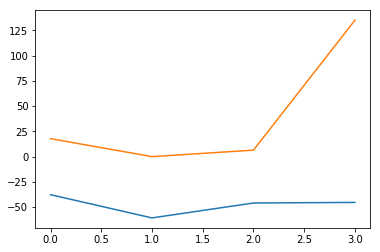

In [21]:
# print losses
print("Training for {} min".format((end_time-start_time)/60))
plt.plot(overall_loss_d)
plt.plot(overall_loss_g)
plt.ylabel("Loss")
plt.xlabel("Episode")
plt.show()

# Plot Created images by the Generator in each training epoch

0 == Fake and 1 == Real
First Episode unsure since untrained on Real Data


TypeError: 'AxesSubplot' object is not subscriptable

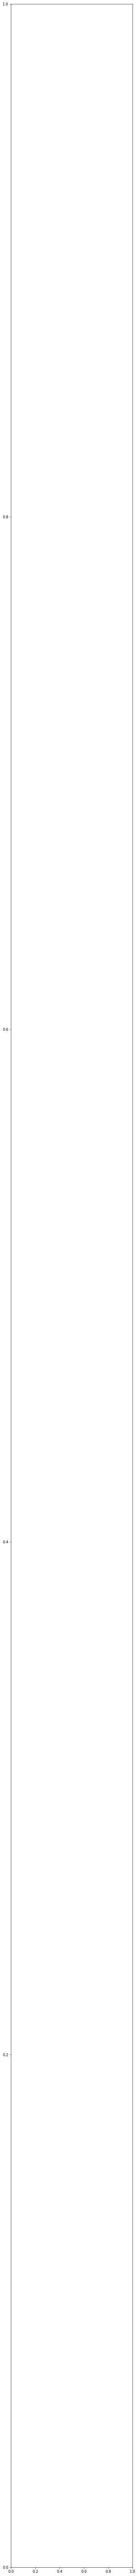

In [68]:
fig, axes = plt.subplots(len(saved_generator_imgs),1, figsize=(6, 130))
fig.subplots_adjust(hspace = .2, wspace=.001)
axes = axes.ravel()

print("0 == Fake and 1 == Real")
print("First Episode unsure since untrained on Real Data")

for idx in range(len(saved_generator_imgs)):
    axes[idx].axis('off')
    axes[idx].imshow(saved_generator_imgs[idx], cmap = "gray")
    axes[idx].set_title(generator_predictions[idx].detach().numpy())

# Plotting Cluster

In [151]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.cm as cm
tsne = TSNE(n_components=2, verbose=1, init='pca', random_state=42)

In [152]:
imgs, labels = next(iter(data_loader))
enc_zn, enc_zc, enc_zc_logits = encoder(imgs.unsqueeze(1))
enc = np.hstack((enc_zn.detach().numpy(), enc_zc_logits.detach().numpy()))
tsne_enc = tsne.fit_transform(enc)
labels = labels.data.numpy()

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 32 samples in 0.001s...
[t-SNE] Computed neighbors for 32 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 32 / 32
[t-SNE] Mean sigma: 24593.521098
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.819187
[t-SNE] KL divergence after 1000 iterations: 0.698653


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

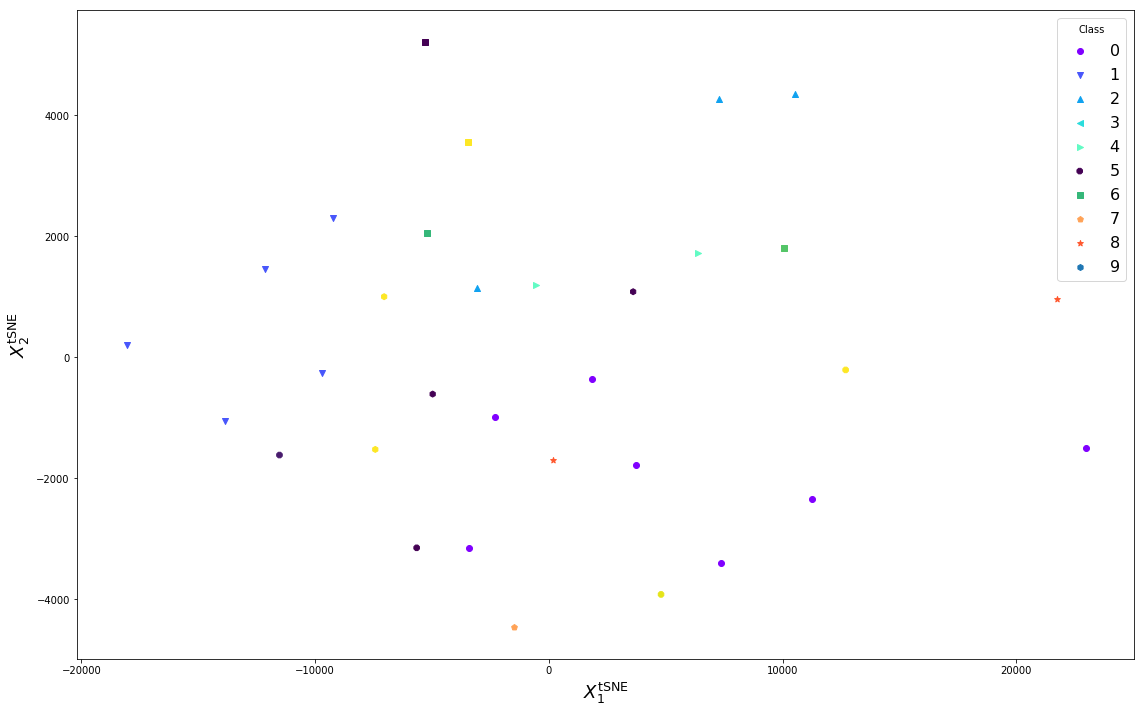

In [153]:
colors = cm.rainbow(np.linspace(0, 1, nr_c))
markers = matplotlib.markers.MarkerStyle.filled_markers

    # Save TSNE figure to file
fig, ax = plt.subplots(figsize=(16,10))
for iclass in range(0, nr_c):
        # Get indices for each class
    idxs = labels==iclass
        # Scatter those points in tsne dims
    ax.scatter(tsne_enc[idxs, 0],
                tsne_enc[idxs, 1],
                marker=markers[iclass],
                c=colors[iclass],
                edgecolor=None,
                label=r'$%i$'%iclass)

    #ax.set_title(r'%s'%fig_title, fontsize=24)
    ax.set_xlabel(r'$X^{\mathrm{tSNE}}_1$', fontsize=18)
    ax.set_ylabel(r'$X^{\mathrm{tSNE}}_2$', fontsize=18)
    plt.legend(title=r'Class', loc='best', numpoints=1, fontsize=16)
    plt.tight_layout()
    fig.savefig('tsne-pca.png')

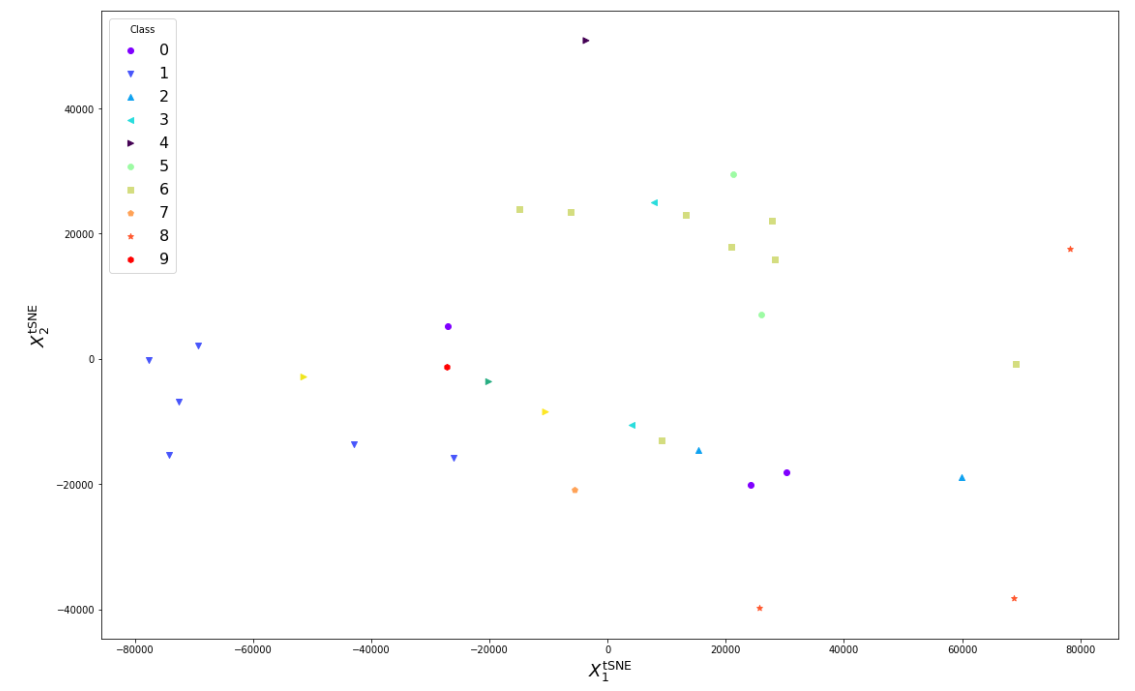